# Neural-Network Quantum States VMC
We construct a neural-network wavefunction and use variational Monte Carlo to approximate the ground-state energy of the one-dimensional quartic anharmonic oscillator
\[ H = -	frac{1}{2}
rac{d^2}{dx^2} + 	frac{1}{2}x^2 + \lambda x^4. \]
Key stability measures:
- double precision throughout with optional CUDA support
- persistent Metropolis-Hastings chains with burn-in and tunable step size
- exponential moving-average energy baseline plus gradient clipping to control stochastic gradients
- diagnostics for acceptance rate, energy trend, and statistical error estimates


## Workflow
1. Define a neural network that outputs the log-amplitude of the wavefunction.
2. Sample configurations from \(|\psi(x)|^2\) using a Metropolis-Hastings random walk.
3. Estimate the local energy \(E_	ext{loc}(x)\) for the quartic oscillator and update the network parameters via adam -stochastic reconfiguration gradients.-
4. Monitor convergence and report the resulting ground-state energy with statistical error bars.


In [2]:
import math
import time
from dataclasses import dataclass
from typing import Dict, List

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn.utils import clip_grad_norm_



In [3]:

@dataclass
class VMCConfig:
    lam: float = 1
    step_size: float = 0.01
    burn_in: int = 100
    n_walkers: int = 512 * 8
    steps_per_epoch: int = 8
    n_epochs: int = 300
    learning_rate: float = 5e-3
    grad_clip: float = 5.0
    init_scale: float = 0.5
    ema_decay: float = 0.9
    eval_steps: int = 5


In [4]:
class LogPsiNet(nn.Module): #input x and outputs log |ψ(x)|
    """Simple fully-connected network that returns log|psi(x)|."""
#Input → Linear → SiLU → Linear → SiLU → Linear → SiLU → Linear → Output
    def __init__(self, hidden_layers=(64, 64, 64)): #neurons in each layer
        super().__init__()
        layers: List[nn.Module] = []
        in_features = 1 # start with no layers and 1 input feature (the position x).
        for width in hidden_layers:
            layers.append(nn.Linear(in_features, width))
            layers.append(nn.SiLU()) #better activation layer for gradiants
            in_features = width
        layers.append(nn.Linear(in_features, 1)) #outputs a single scalar: log |psi(x)|.
        self.network = nn.Sequential(*layers) #runlayers in order
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(module): #y = W x + b
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight) #chooses based on # of input & outputs of the neuron
            nn.init.zeros_(module.bias) #b = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


In [5]:
def quartic_potential(x: torch.Tensor, lam: float) -> torch.Tensor:
    return 0.5 * x.pow(2) + lam * x.pow(4)


def local_energy(model: nn.Module, positions: torch.Tensor, lam: float):
    """Return local energy and log|psi| for the provided positions."""
    x = positions.clone().detach().requires_grad_(True)
    log_psi = model(x).squeeze(-1)
    grad_log_psi = torch.autograd.grad(log_psi.sum(), x, create_graph=True)[0]
    lap_log_psi = torch.autograd.grad(
        grad_log_psi,
        x,
        grad_outputs=torch.ones_like(grad_log_psi),
        create_graph=True,
    )[0]
    kinetic = -0.5 * (lap_log_psi + grad_log_psi.pow(2)) #True. we did this since we only have log psi
    potential = quartic_potential(x, lam)
    local_E = kinetic + potential
    return local_E.squeeze(-1), log_psi


In [6]:

class MetropolisSampler:
    """Persistent Metropolis-Hastings sampler for |psi(x)|^2."""

    def __init__(self, model: nn.Module, step_size=0.6, burn_in=200, init_scale=0.5):
        self.model = model
        self.step_size = step_size
        self.burn_in = burn_in
        self.init_scale = init_scale
        self._positions: torch.Tensor | None = None
        self._log_psi: torch.Tensor | None = None

    def _ensure_state(self, walkers: int):
        """Initialize cached chains/log amps when walker count changes."""
        if self._positions is not None and self._positions.shape[0] == walkers:
            return #If positions already exist with the same number of walkers → do nothing. ??

        device = next(self.model.parameters()).device
        self._positions = self.init_scale * torch.randn(walkers, 1, device=device)
        self._log_psi = self.model(self._positions).squeeze(-1)

    @torch.no_grad()
    def sample(self, steps_after_burn: int, walkers: int):
        """Generate samples via Metropolis updates and return mean acceptance."""
        self._ensure_state(walkers)
        positions, log_psi = self._positions, self._log_psi
        accept_sum, batches = 0.0, []
        total_steps = self.burn_in + steps_after_burn

        for step in range(total_steps):
            proposal = positions + self.step_size * torch.randn_like(positions)
            log_psi_prop = self.model(proposal).squeeze(-1)
            accept_prob = torch.exp(torch.clamp(2.0 * (log_psi_prop - log_psi), max=0.0)) #Because we use log|ψ|, and probability density is |ψ|².
            accepts = torch.rand_like(accept_prob) < accept_prob
            positions = torch.where(accepts.unsqueeze(-1), proposal, positions)
            log_psi = torch.where(accepts, log_psi_prop, log_psi)
            accept_sum += accepts.double().mean().item()

            if step >= self.burn_in:
                batches.append(positions.detach().clone())
                if len(batches) == steps_after_burn:
                    break

        self._positions = positions.detach().clone()
        self._log_psi = log_psi.detach().clone()
        samples = torch.cat(batches, dim=0) if batches else positions.detach().clone()[:0]
        return samples, accept_sum / max(1, total_steps)


In [7]:


def train_vmc(model: nn.Module, config: VMCConfig):
    """Run variational Monte Carlo optimization and log per-epoch diagnostics."""
    model.train()
    sampler = MetropolisSampler(
        model,
        step_size=config.step_size,
        burn_in=config.burn_in,
        init_scale=config.init_scale,
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    history: List[Dict[str, float]] = []
    ema_energy = None
    start = time.time()

    for epoch in range(1, config.n_epochs + 1):
        batch, acc_rate = sampler.sample(config.steps_per_epoch, config.n_walkers)
        local_E, log_psi = local_energy(model, batch, config.lam)
        stats = local_E.detach()
        energy_val = stats.mean().item()
        std_val = stats.std(unbiased=False).item()
        ema_energy = energy_val if ema_energy is None else config.ema_decay * ema_energy + (1.0 - config.ema_decay) * energy_val
        # Reconfiguration objective: minimize ⟨(E - E_ref) ∂ log ψ⟩ with E_ref = ema_energy
        loss = torch.mean((stats - ema_energy) * log_psi)

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), config.grad_clip)
        optimizer.step()

        history.append({
            'epoch': epoch,
            'energy': energy_val,
            'std_energy': std_val,
            'acceptance': acc_rate,
            'loss': loss.item(),
        })

        if epoch % max(1, config.n_epochs // 10) == 0 or epoch == 1:
            print(
                f"Epoch {epoch:4d} | E = {energy_val:.6f} ± {std_val:.6f} | "
                f"acc = {acc_rate:.2f} | loss = {loss.item():.6f}"
            )

    print(f"Training completed in {time.time() - start:.1f} s")
    return history, sampler


def estimate_ground_state(model: nn.Module, config: VMCConfig, sampler: MetropolisSampler | None = None, n_eval_steps: int | None = None):
    """Freeze model parameters, draw fresh samples, and report ⟨E⟩ ± σ/√N."""
    model.eval()
    sampler = sampler or MetropolisSampler(
        model,
        step_size=config.step_size,
        burn_in=config.burn_in,
        init_scale=config.init_scale,
    )
    steps = n_eval_steps if n_eval_steps is not None else config.eval_steps
    samples, acc_rate = sampler.sample(steps, config.n_walkers)
    stats = local_energy(model, samples, config.lam)[0].detach()
    mean_E = stats.mean().item()
    stderr = stats.std(unbiased=False).item() / max(1, stats.shape[0]) ** 0.5
    print(f"Ground-state energy ≈ {mean_E:.6f} ± {stderr:.6f} (stat) | acc = {acc_rate:.2f}")
    return mean_E, stderr, acc_rate


In [ ]:

# Default configuration and model
config = VMCConfig(
    lam=20000,
    step_size=0.001,
    burn_in=100,
    n_walkers=512*8 ,
    steps_per_epoch=8,
    n_epochs=900,
    learning_rate=5e-3,
    grad_clip=0.1,
    init_scale=0.1,
    ema_decay=0.5,
    eval_steps=5,
)
model = LogPsiNet(hidden_layers=(8,8,8))

# Run the variational optimization (takes a few minutes on CPU, faster on GPU)
history, sampler = train_vmc(model, config)

mean_E, stderr_E, acc = estimate_ground_state(model, config, sampler=sampler, n_eval_steps=config.eval_steps)
print({'E_mean': mean_E, 'E_stderr': stderr_E, 'acceptance': acc})


Epoch    1 | E = 6.186463 ± 19.821802 | acc = 1.00 | loss = -0.002931
Epoch   90 | E = 22.512932 ± 58.597496 | acc = 1.00 | loss = -4.483234
Epoch  180 | E = 17.806065 ± 20.618013 | acc = 1.00 | loss = 0.167099
Epoch  270 | E = 18.112110 ± 2.592581 | acc = 1.00 | loss = 0.233069
Epoch  360 | E = 18.132498 ± 1.277013 | acc = 1.00 | loss = 0.160040


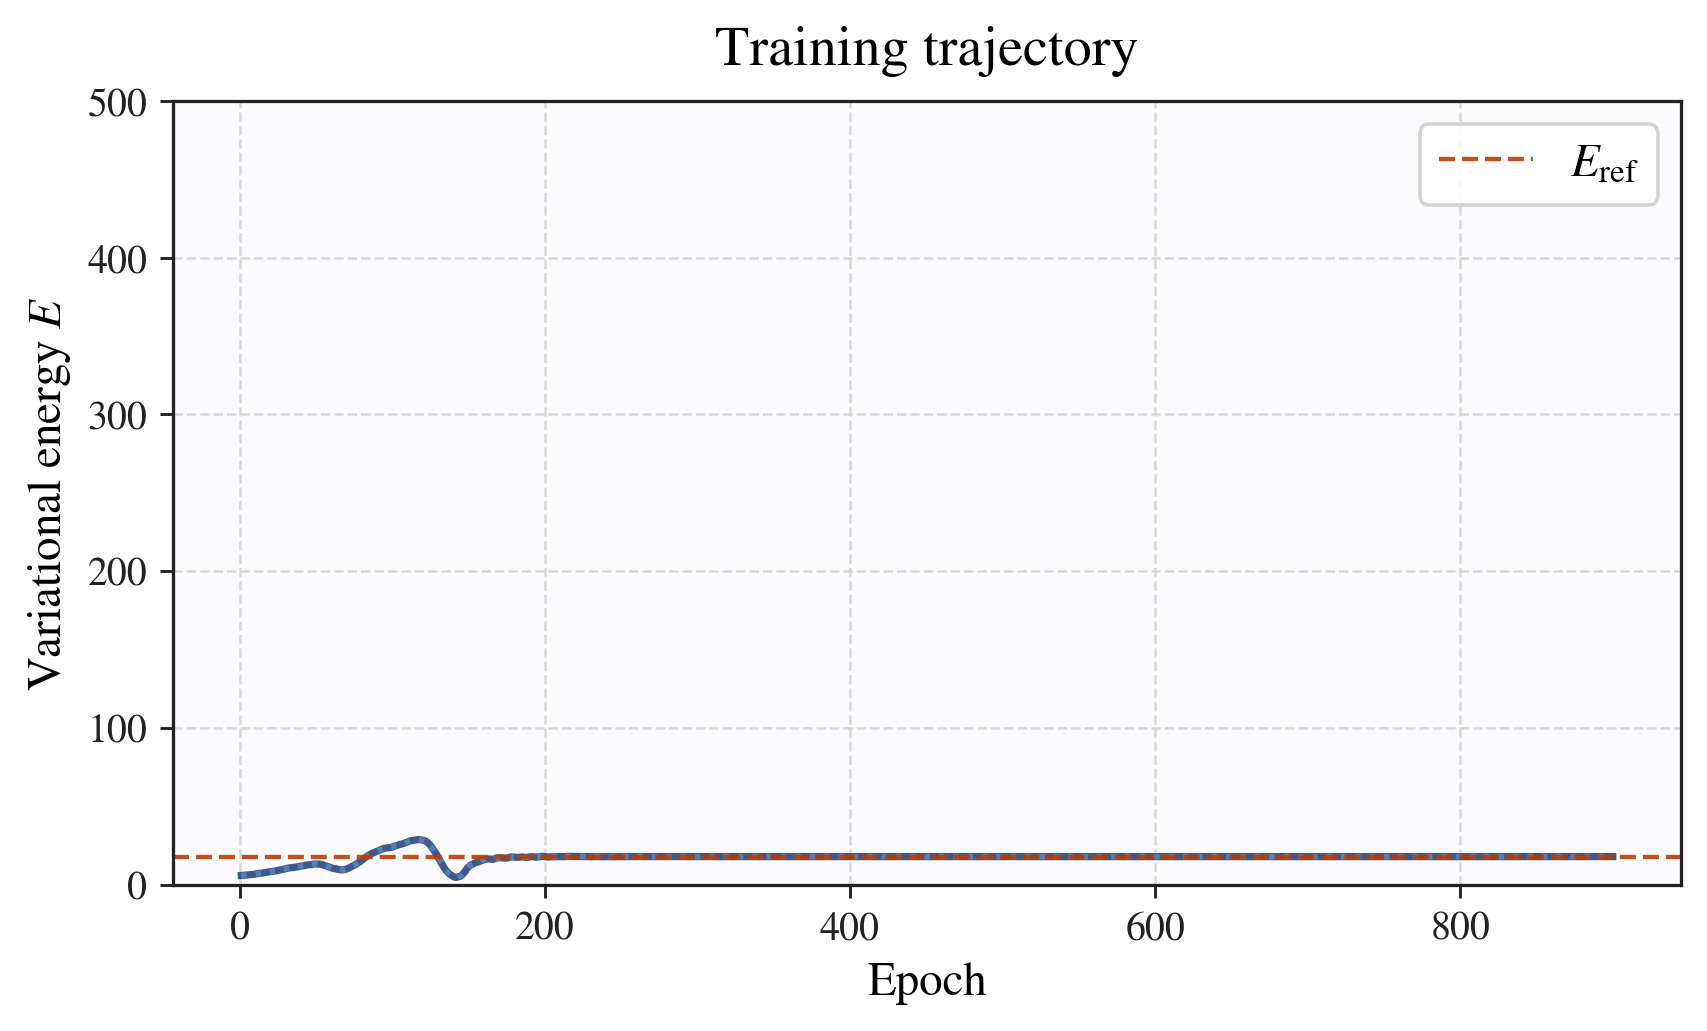

In [92]:
# Visualize the energy trajectory
epochs = [entry['epoch'] for entry in history]
energies = [entry['energy'] for entry in history]

plt.rcParams.update(
    {
        'font.family': 'STIXGeneral',
        'mathtext.fontset': 'stix',
        'font.size': 13,
    }
)

fig, ax = plt.subplots(figsize=(6.8, 4.2), dpi=260)
ax.plot(
    epochs,
    energies,
    color='#1f3d7a',
    linewidth=2.0,
    alpha=0.85,
)
ax.plot(
    epochs,
    energies,
    color='#6fa4d8',
    linewidth=1.5,
    linestyle=':',
    alpha=0.5,
)
ax.axhline(18.13, color='#bb3e03', linestyle='--', linewidth=1.2, alpha=0.9, label=r'$E_{\mathrm{ref}}$')
ax.set_ylim(0, 500)
ax.set_xlabel('Epoch')
ax.set_ylabel(r'Variational energy $E$')
ax.set_title('Training trajectory', pad=10)
ax.grid(True, which='major', color='#d0d0d0', linestyle='--', linewidth=0.7, alpha=0.8)
ax.set_facecolor('#fbfbfd')
for spine in ax.spines.values():
    spine.set_color('#222222')
    spine.set_linewidth(0.9)
ax.tick_params(axis='both', colors='#222222', labelsize=11)
ax.legend(loc='upper right', frameon=True, framealpha=0.85)
fig.tight_layout(pad=1.2)
plt.show()


In [93]:

# High-statistics energy estimate
mean_E, stderr_E, acc = estimate_ground_state(model, config, sampler=sampler, n_eval_steps=config.eval_steps)
print({'E_mean': mean_E, 'E_stderr': stderr_E, 'acceptance': acc})


Ground-state energy ≈ 18.146738 ± 0.005969 (stat) | acc = 1.00
{'E_mean': 18.146738052368164, 'E_stderr': 0.0059690776766385695, 'acceptance': 0.9969587053571428}
